# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. We filter the single cells by identifying outliers with z-scores, and use either combinations of features or one feature for each condition. We use features from the AreaShape and Intensity modules to assess the quality of the segmented single-cells:

### Assessing poor nuclei segmentation

Due to high confluence, sometimes nuclei overlap on top of each other, creating highly intense clusters within the Hoechst channel. To identify these nuclei, we use:

- **Nuclei Area:** This metric quantifies the number of pixels in a nucleus segmentation. 
We detect nuclei that are abnormally large, which likely indicates poor nucleus segmentation where overlapping nuclei are merged into one segmentation. 
- **Nuclei Intensity:** This metric quantifies the total intensity of all pixels in a nucleus segmentation. 
  
In combination with abnormally large nuclei, we detect nuclei that are also highly intense, likely indicating that this a group of overlapped nuclei.

`We utilize the same thresholds for this section as set in the [cellpainting_predicts_cardiac_fibroblasts](https://github.com/WayScience/cellpainting_predicts_cardiac_fibrosis) repository.`

We decided in this notebook to also include finding nuclei with very **LOW** intensity which more than likely correlates with mis-segmented nuclei from the background. 
These occur due to very cytotoxic compounds that kill all the cells, leaving empty FOVs where the segmentation parameters sometimes decides to segment nuclei from nothing.

`We determine our own threshold using the first batch of data (4 plates from layout one) that we will use for the rest of the plates.`

### Assessing poor cell segmentation

Also due to high confluence, images with large, intense clusters of cells leads to errors in the segmentation algorithm that causes cells around the cluster to segmented incorrectly. 
When this happens, a cell is segmented around the same segmentation as the nucleus, giving it the same area which is very small for a normal cardiac fibroblast cell. To detect poorly segmented cells, we use:

- **Cells area:** The cells Area metric quantifies the number of pixels in a cell segmentation.

`We update the threshold for this dataset from the original thresholds since we determined that there were too many good cells being removed. We update the threshold to be more loose.`

In [1]:
import os
import pathlib
import re

import matplotlib

matplotlib.use("Agg")  # Ensures no GUI windows are opened
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display
from cytodataframe import CytoDataFrame
from cosmicqc import find_outliers

## Set paths and variables

In [2]:
# Optional: set `BATCH` and `PLATEMAP_LAYOUT` env vars to process a specific batch and platemap
batch_to_process = os.environ.get("BATCH", "batch_2")
print(f"Processing batch: {batch_to_process}")

# Set base directory for where the SQLite files are located (should be local to repo)
base_dir = pathlib.Path(
    f"../2.cellprofiler_processing/cp_output/{batch_to_process}"
).resolve(strict=True)

Processing batch: batch_2


In [3]:
# Set parameters for papermill to use for processing
platemap_layout = "platemap_7"
plate_id = "CARD-CelIns-CX7_260102130001"

In [4]:
# Directory with data
data_dir = pathlib.Path(
    f"./data/{batch_to_process}/{platemap_layout}/converted_profiles/"
).resolve(strict=True)

# Directory to save cleaned data
cleaned_dir = pathlib.Path(
    f"./data/{batch_to_process}/{platemap_layout}/cleaned_profiles/"
)
cleaned_dir.mkdir(parents=True, exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path(f"./qc_figures/{batch_to_process}/{platemap_layout}")
qc_fig_dir.mkdir(parents=True, exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# Metadata columns to include in output data frame (based on compartment)
nuclei_metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
    "Image_PathName_DNA",
    "Image_FileName_DNA",
    "Nuclei_AreaShape_BoundingBoxMaximum_X",
    "Nuclei_AreaShape_BoundingBoxMaximum_Y",
    "Nuclei_AreaShape_BoundingBoxMinimum_X",
    "Nuclei_AreaShape_BoundingBoxMinimum_Y",
]
cells_metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Cells_Location_Center_X",
    "Metadata_Cells_Location_Center_Y",
    "Image_PathName_DNA",
    "Image_FileName_DNA",
    "Cells_AreaShape_BoundingBoxMaximum_X",
    "Cells_AreaShape_BoundingBoxMaximum_Y",
    "Cells_AreaShape_BoundingBoxMinimum_X",
    "Cells_AreaShape_BoundingBoxMinimum_Y",
]

## Load in plate to perform QC on

In [5]:
# Set plate path
plate_path = pathlib.Path(f"{data_dir}/{plate_id}_converted.parquet").resolve(
    strict=True
)

# Load the converted plate data
plate_df = pd.read_parquet(plate_path)

# Print the shape of the DataFrame for each plate
print(f"Loaded plate: {plate_path.stem}, Shape: {plate_df.shape}")

Loaded plate: CARD-CelIns-CX7_260102130001_converted, Shape: (5443, 2320)


## Correct pathing to local to find images

In [6]:
# Fix image paths to point to corrected images
correct_parent = "/home/jenna"

for col in plate_df.columns:
    if "PathName" in col and "Illum" not in col:
        plate_df[col] = plate_df[col].apply(
            lambda x: (
                re.sub(r"^.*jtomkinson@xsede.org/", correct_parent + "/", x)
                if isinstance(x, str)
                else x
            )
        )

# Print example image path after fix
print(plate_df["Image_PathName_DNA"].dropna().iloc[0])

/home/jenna/targeted_fibrosis_drug_screen/1.illumination_correction/Corrected_Images/batch_2/platemap_7/CARD-CelIns-CX7_260102130001


In [7]:
# Print example image file
print(plate_df["Image_FileName_DNA"].dropna().iloc[0])

CARD-CelIns-CX7_260102130001_B02f07d4_illumcorrect.tiff


## Set mapping for outlines

In [8]:
# Set current compartment as Nuclei
compartment = "Nuclei"

# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {
    rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff": 
    rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}{record['Image_Metadata_Site']}.*\.tiff"
    for record in plate_df[
        ["Image_Metadata_Plate", "Image_Metadata_Well", "Image_Metadata_Site"]
    ].to_dict(orient="records")
}

# fmt: on

next(iter(outline_to_orig_mapping.items()))

('NucleiOutlines_CARD-CelIns-CX7_260102130001_B02_f07.tiff',
 'CARD-CelIns-CX7_260102130001_B02f07.*\\.tiff')

## Detect over-segmented nuclei using shape and intensity

Number of outliers: 145 (2.66%)
Outliers Range:
Nuclei_AreaShape_Area Min: 2249.0
Nuclei_AreaShape_Area Max: 5604.0
Nuclei_Intensity_IntegratedIntensity_DNA Min: 125.8686354784295
Nuclei_Intensity_IntegratedIntensity_DNA Max: 505.6731256041676
(145, 3)


,321,2955,4926,5141,3474
Nuclei_AreaShape_Area,2256.0,2285.0,2899.0,2476.0,2507.0
Nuclei_Intensity_IntegratedIntensity_DNA,160.982773,146.215961,150.683925,169.100893,140.263936
Image_FileName_DNA,,,,,

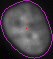
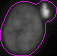
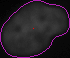
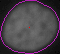
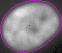

In [9]:
feature_thresholds_large_nuclei_high_int = {
    "Nuclei_AreaShape_Area": 2,
    "Nuclei_Intensity_IntegratedIntensity_DNA": 2,
}

# Find large nuclei outliers for the current plate
large_nuclei_high_int_outliers = find_outliers(
    df=plate_df,
    metadata_columns=nuclei_metadata_columns,
    feature_thresholds=feature_thresholds_large_nuclei_high_int,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
large_nuclei_high_int_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(large_nuclei_high_int_outliers),
    data_outline_context_dir=f"../2.cellprofiler_processing/cp_output/{batch_to_process}/{platemap_layout}/{plate_id}",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": True,
        "brightness": 1,
        "outline_color": (180, 30, 180),
    },
)[
    [
        "Nuclei_AreaShape_Area",
        "Nuclei_Intensity_IntegratedIntensity_DNA",
        "Image_FileName_DNA",
    ]
]

if not large_nuclei_high_int_outliers_cdf.empty:
    print(large_nuclei_high_int_outliers_cdf.shape)
    # large_nuclei_high_int_outliers_cdf.sort_values(
    #     by="Nuclei_AreaShape_Area", ascending=True
    # ).head(2).T
    display(large_nuclei_high_int_outliers_cdf.sample(n=5).T)
else:
    print("No large nuclei high intensity outliers detected.")

## Detect mis-segmented background as nuclei

Number of outliers: 63 (1.16%)
Outliers Range:
Nuclei_Intensity_IntegratedIntensity_DNA Min: 0.4532997633796185
Nuclei_Intensity_IntegratedIntensity_DNA Max: 53.408896101638675
(63, 2)


,2541,2730,5305,2932,798
Nuclei_Intensity_IntegratedIntensity_DNA,49.187183,37.82649,51.50335,33.209125,23.367575
Image_FileName_DNA,,,,,

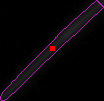
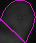
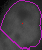
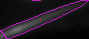
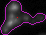

In [10]:
# Set feature thresholds for low total intensity
feature_thresholds_low_intensity = {
    "Nuclei_Intensity_IntegratedIntensity_DNA": -1,
}

# Find low intensity nuclei outliers for the current plate
low_intensity_outliers = find_outliers(
    df=plate_df,
    metadata_columns=nuclei_metadata_columns,
    feature_thresholds=feature_thresholds_low_intensity,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
low_intensity_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(low_intensity_outliers),
    data_outline_context_dir=f"../2.cellprofiler_processing/cp_output/{batch_to_process}/{platemap_layout}/{plate_id}",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": True,
        "brightness": 1,
        "outline_color": (180, 30, 180),
    },
)[
    [
        "Nuclei_Intensity_IntegratedIntensity_DNA",
        "Image_FileName_DNA",
    ]
]

if not low_intensity_outliers_cdf.empty:
    print(low_intensity_outliers_cdf.shape)
    # low_intensity_outliers_cdf.sort_values(
    #     by="Nuclei_Intensity_IntegratedIntensity_DNA", ascending=False
    # ).head(5).T
    display(low_intensity_outliers_cdf.sample(n=5, random_state=0).T)
else:
    print("No low intensity nuclei outliers detected.")

## Detect under-segmented cells

### Set up outlines for cells

In [11]:
# Set current compartment as Cells
compartment = "Cells"

# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {
    rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff": 
    rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}{record['Image_Metadata_Site']}.*\.tiff"
    for record in plate_df[
        ["Image_Metadata_Plate", "Image_Metadata_Well", "Image_Metadata_Site"]
    ].to_dict(orient="records")
}

# fmt: on

next(iter(outline_to_orig_mapping.items()))

('CellsOutlines_CARD-CelIns-CX7_260102130001_B02_f07.tiff',
 'CARD-CelIns-CX7_260102130001_B02f07.*\\.tiff')

In [12]:
# Set feature thresholds for small cells
feature_thresholds_small_cells = {
    "Cells_AreaShape_Area": -1.5,
}

# Find under-segmented cells outliers for the current plate
small_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=cells_metadata_columns,
    feature_thresholds=feature_thresholds_small_cells,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
small_cells_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(small_cells_outliers),
    data_outline_context_dir=f"../2.cellprofiler_processing/cp_output/{batch_to_process}/{platemap_layout}/{plate_id}",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": True,
        "brightness": 1,
        "outline_color": (180, 30, 180),
    },
)[
    [
        "Cells_AreaShape_Area",
        "Image_FileName_DNA",
    ]
]

if not small_cells_outliers_cdf.empty:
    print(small_cells_outliers_cdf.shape)
    # small_cells_outliers_cdf.sort_values(by="Cells_AreaShape_Area", ascending=False).head(5).T
    display(small_cells_outliers_cdf.sample(n=5, random_state=0).T)
else:
    print("No small cells outliers detected.")

Number of outliers: 0 (0.00%)
Outliers Range:
Cells_AreaShape_Area Min: nan
Cells_AreaShape_Area Max: nan
No small cells outliers detected.


## Filter outliers and save cleaned data for the plate

In [13]:
# Find the outliers indices to determine failed single-cells
outlier_indices = pd.concat(
    [large_nuclei_high_int_outliers, small_cells_outliers, low_intensity_outliers]
).index

# Remove rows with outlier indices from the plate DataFrame
plate_df_cleaned = plate_df.drop(outlier_indices)

# Calculate the total percentage of nuclei that failed QC
total_nuclei = plate_df.shape[0]
total_failed = len(outlier_indices)
percent_failed = (total_failed / total_nuclei) * 100 if total_nuclei > 0 else 0

# Save cleaned data for this plate
plate_cleaned_name = plate_df["Image_Metadata_Plate"].iloc[0]
plate_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_cleaned_name}_cleaned.parquet")

# Verify the result and include the percentage of failed QC
print(
    f"Cleaned data saved for plate {plate_cleaned_name}. Shape: {plate_df_cleaned.shape}. Total percent nuclei failed QC: {percent_failed:.2f}%"
)

Cleaned data saved for plate CARD-CelIns-CX7_260102130001. Shape: (5235, 2320). Total percent nuclei failed QC: 3.82%


In [14]:
# Set the default value to 'Single-cell passed QC'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Label each outlier type, excluding small cells
plate_df.loc[
    plate_df.index.isin(large_nuclei_high_int_outliers.index), "Outlier_Status"
] = "Over-segmented nuclei"

plate_df.loc[plate_df.index.isin(low_intensity_outliers.index), "Outlier_Status"] = (
    "Mis-segmented nuclei"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plate_df,
    x="Nuclei_AreaShape_Area",
    y="Nuclei_Intensity_IntegratedIntensity_DNA",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Over-segmented nuclei": "#990090",
        "Mis-segmented nuclei": "#D55E00",
    },
    alpha=0.6,
)

# Add threshold lines
plt.axvline(
    x=large_nuclei_high_int_outliers["Nuclei_AreaShape_Area"].min(),
    color="r",
    linestyle="--",
    label="Min. threshold for Nuclei Area",
)
plt.axhline(
    y=large_nuclei_high_int_outliers["Nuclei_Intensity_IntegratedIntensity_DNA"].min(),
    color="b",
    linestyle="--",
    label="Min. threshold for Nuclei Intensity",
)

# Add title and labels
plt.title(f"Nuclei Area vs. Integrated Intensity ({plate_id})")
plt.xlabel("Nuclei Area")
plt.ylabel("Nuclei Integrated Intensity (DNA)")
plt.tight_layout()

# Show the legend
plt.legend(loc="upper left", bbox_to_anchor=(0, 1.0), prop={"size": 10})

# Save the figure with plate_id in filename
plt.savefig(qc_fig_dir / f"{plate_id}_nuclei_outliers.png", dpi=500)
plt.close()

In [15]:
# Create KDE plot of all cells
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=plate_df["Cells_AreaShape_Area"],
    fill=True,
    color="#4682B4",  # steel blue
    alpha=0.6,
)

# Add threshold line for small cells
plt.axvline(
    x=small_cells_outliers["Cells_AreaShape_Area"].max(),
    color="r",
    linestyle="--",
    label=f'Small cells threshold: < {small_cells_outliers["Cells_AreaShape_Area"].max():.2f}',
)

# Labels and title
plt.ylabel("Density")
plt.xlabel("Cells Area")
plt.title(f"Distribution of Cell Areas ({plate_id})")
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig(qc_fig_dir / f"{plate_id}_small_cell_outliers.png", dpi=500)
plt.close()